_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Kathrin Root, Alexander Wendt, Patrick Weygoldt

# Coding Lab 5



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io

%matplotlib inline

plt.style.use("../matplotlib_style.txt")

## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*


### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

$$L(\omega) = \log(\prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t))$$
$$with\: \log(ab) = log(a) + log(b), \: a = \frac{r_t^{c_t}}{c_t!},\: b = \exp(-r_t)$$
$$L(\omega) = \sum_t \log(\frac{r_t^{c_t}}{c_t!})+\log(\exp(-r_t))$$
$$L(\omega) = \sum_t \log(r_t^{c_t})-\log(c_t!)-r_t$$ 
$$with \: r_t = \exp(w^T s_t) \cdot \Delta t \cdot R$$
$$ L(\omega) = \sum_t \log((\exp(w^T s_t) \cdot \Delta t \cdot R)^{c_t})-\log(c_t!)-\exp(w^T s_t) \cdot \Delta t \cdot R$$
$$ L(\omega) = \sum_t c_t (w^T s_t + \log(\Delta t) + \log(R)) - \log(c_t!) - \exp(w^T s_t) \cdot \Delta t \cdot R$$

derivative of $L(\omega)$ with respect to $\omega$ can be devided into three parts:
the first part yields:
$$\frac{dL(\omega)}{d\omega} = c_t (w^T s_t + \log(\Delta t) + \log(R)) $$
$$\frac{dL(\omega)}{d\omega} = c_t  s_t$$
the second part yields:
$$\frac{dL(\omega)}{d\omega} = -\log(c_t!)$$
$$\frac{dL(\omega)}{d\omega} = 0$$
the third part yields:
$$\frac{dL(\omega)}{d\omega} = -\exp(w^T s_t) \cdot \Delta t \cdot R$$
$$\frac{dL(\omega)}{d\omega} = -s_t \exp(w^T s_t) \cdot \Delta t \cdot R$$
combining the three parts yields:
$$\frac{dL(\omega)}{d\omega} = \sum_t c_t  s_t -s_t \exp(w^T s_t) \cdot \Delta t \cdot R$$
$$\frac{dL(\omega)}{d\omega} = \sum_t s_t (c_t - \exp(w^T s_t) \cdot \Delta t \cdot R)$$

### Generate data

Text(0.5, 1.0, 'Gaussian RF')

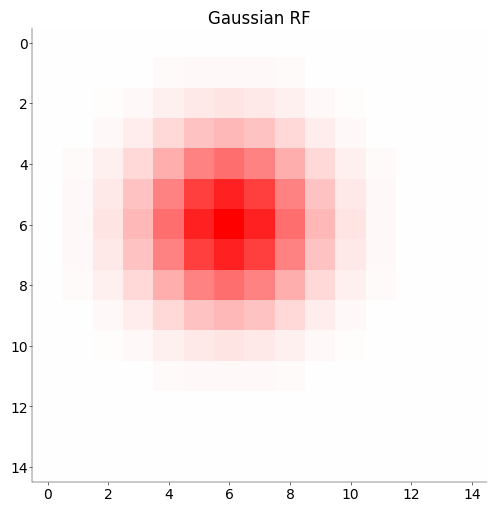

In [2]:
def gen_gauss_rf(D, width, center=(0,0)):
    
    sz = (D-1)/2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w

w = gen_gauss_rf(15,7,(1,1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(w, cmap='bwr', vmin=-vlim, vmax=vlim)
ax.set_title('Gaussian RF')

In [3]:
def sample_lnp(w, nT, dt, R, v):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    v: float
        variance of the stimulus

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.
    $$
    c_t \sim Poisson(r_t)\\
    r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
    $$

    """

    np.random.seed(10) 
    stimulus = np.random.choice([0,1], (w.shape[0], nT))
    stimulus = stimulus * np.sqrt(v)
    
    mean_rate = np.exp(w.T @ stimulus) * dt * R
    spike_counts = np.random.poisson(mean_rate)  

    return spike_counts, mean_rate , stimulus

In [4]:
D = 15     # number of pixels
nT = 100000  # number of time bins
dt = 0.1   # bins of 100 ms
R = 50     # firing rate in Hz 
v = 5      # stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()
print(w.shape)

c, r, s = sample_lnp(w, nT, dt, R, v)
print(c.shape, r.shape, s.shape,)
sreshape = s.reshape((D,D,nT))
print(sreshape.shape)

(225,)
(100000,) (100000,) (225, 100000)
(15, 15, 100000)


Plot the responses of the cell.

Text(0.5, 1.0, 'Stimulus frames')

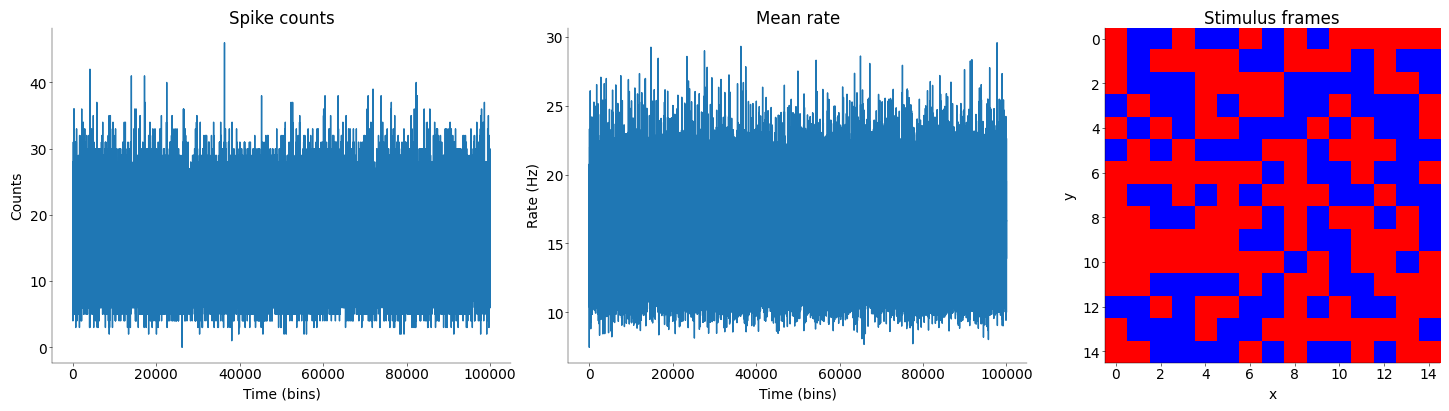

In [5]:

mosaic = "ABC"

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15,4))
ax["A"].plot(c)
ax["A"].set_title("Spike counts")
ax["A"].set_ylabel("Counts")
ax["A"].set_xlabel("Time (bins)")
ax["B"].plot(r)
ax["B"].set_ylabel("Rate (Hz)")
ax["B"].set_xlabel("Time (bins)")
ax["B"].set_title("Mean rate")

ax["C"].imshow(sreshape[:,:,0], cmap='bwr')
ax["C"].set_ylabel("y")
ax["C"].set_xlabel("x") 
ax["C"].set_title("Stimulus frames")

# plot the stimulus grid only for one frame

### Implementation 

Before you run your optimizer, make sure the gradient is correct. The helper function `check_grad` in `scipy.optimize` can help you do that. This package also has suitable functions for optimization. If you generate a large number of  samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [6]:
def L_omega(x, c, s, dt=0.1, R=50):
  '''Implements the negative (!) log-likelihood of the LNP model and its
  gradient with respect to the receptive field w.

  $$ L(\omega) = \sum_t \log(\exp(w^T s_t) \cdot \Delta t \cdot R)^{c_t}-\log(c_t!)-\exp(w^T s_t) \cdot \Delta t \cdot R$$

  Parameters
  ----------

  x: np.array, (Dx * Dy, )
    current receptive field 

  c: np.array, (nT, )
    spike counts 

  s: np.array, (Dx * Dy, nT)
    stimulus matrix


  Returns
  -------

  f: float
    function value of the negative log likelihood at x

  '''
  return - np.sum(c*((x.T @ s) + np.log(dt) + np.log(R)) - np.log([float(np.math.factorial(int(c_single))) for c_single in c]) - np.exp(x.T @ s) * dt * R)


def dL_omega(x, c, s, dt=0.1, R=50):
  '''Implements the negative (!) log-likelihood of the LNP model and its
  gradient with respect to the receptive field w.

  $$ L(\omega) = \sum_t \log(\exp(w^T s_t) \cdot \Delta t \cdot R)^{c_t}-\log(c_t!)-\exp(w^T s_t) \cdot \Delta t \cdot R$$

  Parameters
  ----------

  x: np.array, (Dx * Dy, )
    current receptive field 

  c: np.array, (nT, )
    spike counts 

  s: np.array, (Dx * Dy, nT)
    stimulus matrix


  Returns
  -------
  df: np.array, (Dx * Dy, )
    gradient of the negative log likelihood with respect to x 
  '''
  return - np.sum(s * (c - np.exp(x.T @ s) * dt * R), axis=1)

f = L_omega(w, c, s, dt, R)
df = dL_omega(w, c, s, dt, R)
print(f, df.shape)


277738.56652510294 (225,)


$$ L(\omega) = \sum_t \log((\exp(w^T s_t) \cdot \Delta t \cdot R)^{c_t})-\log(c_t!)-\exp(w^T s_t) \cdot \Delta t \cdot R$$
$$\frac{dL(\omega)}{d\omega} = \sum_t s_t (c_t - \exp(w^T s_t) \cdot \Delta t \cdot R)$$


Fit receptive field maximizing the log likelihood

In [7]:
err = opt.check_grad(L_omega, dL_omega, w, c, s, dt, R)
print(err)

# insert your code here 
res = opt.minimize(L_omega, x0=w, args=(c, s, dt, R), jac=dL_omega, method='BFGS', options={'disp': True, 'maxiter': 1000})
print(np.shape(res))
print(res.x.shape)
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly, 
# minimizing the negative log-likelihood).
# 
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------




0.4733555633301254
         Current function value: 277633.097054
         Iterations: 140
         Function evaluations: 403
         Gradient evaluations: 396
()
(225,)


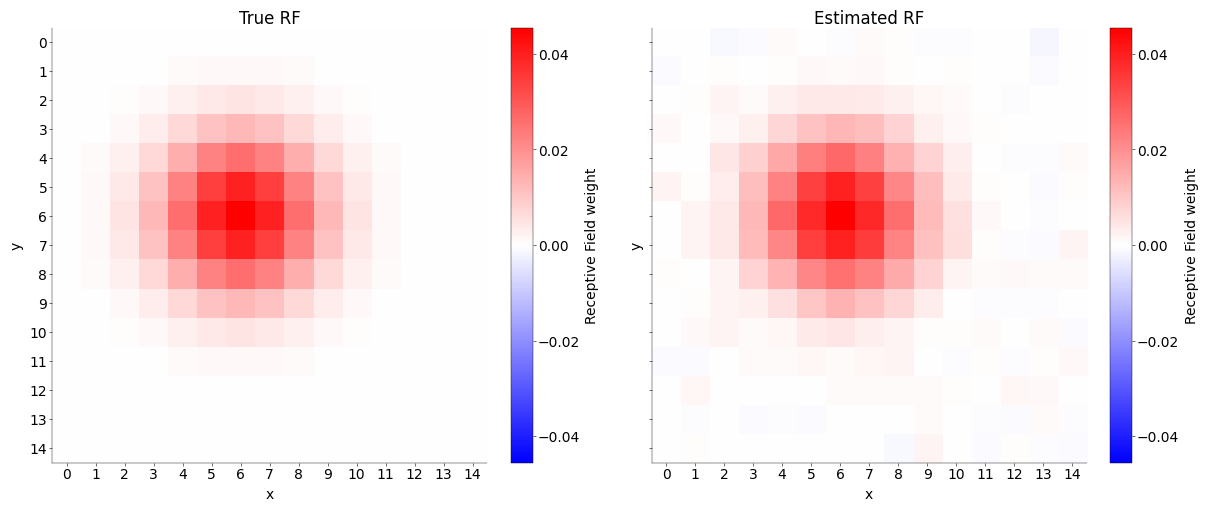

In [8]:
# insert your code here 

# ------------------------------------
# Plot the ground truth and estimated 
# `w` side by side. (0.5 pts)
# ------------------------------------
vlim = np.max(np.abs(w))
mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12,5), sharey=True,)
# plot grid
ax["True"].set_xticks(np.arange(0, D, 1))
ax["True"].set_yticks(np.arange(0, D, 1))
ax["Estimated"].set_xticks(np.arange(0, D, 1))
ax["Estimated"].set_yticks(np.arange(0, D, 1))
ax["True"].set_xlabel("x")
ax["True"].set_ylabel("y")
ax["Estimated"].set_xlabel("x")
ax["Estimated"].set_ylabel("y")

ax["True"].imshow(w.reshape((D,D)), cmap='bwr', vmin=-vlim, vmax=vlim)
ax["True"].set_title("True RF") 
ax["Estimated"].imshow(res.x.reshape((D,D)), cmap='bwr', vmin=-vlim, vmax=vlim)
ax["Estimated"].set_title("Estimated RF")
# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.
# adding colorbar 
cbar1= fig.colorbar(ax["True"].imshow(w.reshape((D,D)), cmap='bwr', vmin=-vlim, vmax=vlim), ax=ax["True"]) 
cbar2=fig.colorbar(ax["Estimated"].imshow(res.x.reshape((D,D)), cmap='bwr', vmin=-vlim, vmax=vlim), ax=ax["Estimated"])
#adding lanbel to colorbar
cbar1.set_label('Receptive Field weight') 
cbar2.set_label('Receptive Field weight')

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [9]:
var = io.loadmat('../data/nds_cl_5_data.mat')

# t contains the spike times of the neuron
t = var['DN_spiketimes'].flatten()    

# trigger contains the times at which the stimulus flipped
trigger = var['DN_triggertimes'].flatten()

# contains the stimulus movie with black and white pixels
s = var['DN_stim']
print(s.shape)
s = s.reshape((300,1500)) # the shape of each frame is (20, 15)
s = s[:,1:len(trigger)]
print(s.shape) 
print(t.shape)
print(trigger.shape)


(20, 15, 1500)
(300, 1488)
(5500,)
(1489,)


Create vector of spike counts

In [10]:
# insert your code here 

# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

spikes = np.zeros((len(trigger)-1)) 
for i in range(len(trigger)-1):
        spikes[i] = len(t[(t>=trigger[i]) & (t<trigger[i+1])])
print(spikes.shape) 
print(spikes[0:10])


(1488,)
[6. 6. 9. 7. 5. 6. 8. 6. 4. 6.]


Fit receptive field for each frame separately

In [11]:
# insert your code here 

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
# 
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------
def gen_gauss_rf_multiD(D,F, width, center=(0,0)):
    
    sz = (D-1)/2
    sy = (F-1)/2
    x, y = np.meshgrid(np.arange(-sy, sy + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w
Dx = 20
Dy = 15

# specify the time lags
delta = [0, 1, 2, 3, 4] 
# intial guess for the receptive field
w0 = gen_gauss_rf_multiD(20, 15, 2)
w0 = w0.flatten()   
print(w0.shape) 

met = 'SLSQP'
cont = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # github copilot
w_hat = np.zeros((Dx*Dy, 5))
for lag in range(5):
    if lag == 0:
        res = opt.minimize(L_omega, x0=w0, args=(spikes, s), jac=dL_omega, method=met, options={'disp': True, 'maxiter': 6000},constraints=cont)
    else:
        res = opt.minimize(L_omega, x0=w0, args=(spikes[lag:], s[:, :-lag]), jac=dL_omega, method=met, options={'disp': True, 'maxiter': 6000},constraints=cont)
    w_hat[:, lag] = res.x

# fit for each delay

(300,)


/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_65691/4143196054.py:27: RuntimeWarning: overflow encountered in exp
  return - np.sum(c*((x.T @ s) + np.log(dt) + np.log(R)) - np.log([float(np.math.factorial(int(c_single))) for c_single in c]) - np.exp(x.T @ s) * dt * R)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5445.70389448282
            Iterations: 44
            Function evaluations: 203
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5384.226517693791
            Iterations: 34
            Function evaluations: 158
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5427.735259719336
            Iterations: 44
            Function evaluations: 204
            Gradient evaluations: 44


/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_65691/4143196054.py:27: RuntimeWarning: overflow encountered in multiply
  return - np.sum(c*((x.T @ s) + np.log(dt) + np.log(R)) - np.log([float(np.math.factorial(int(c_single))) for c_single in c]) - np.exp(x.T @ s) * dt * R)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5424.412949355597
            Iterations: 33
            Function evaluations: 155
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5427.2089886048425
            Iterations: 24
            Function evaluations: 115
            Gradient evaluations: 24


Plot the frames one by one

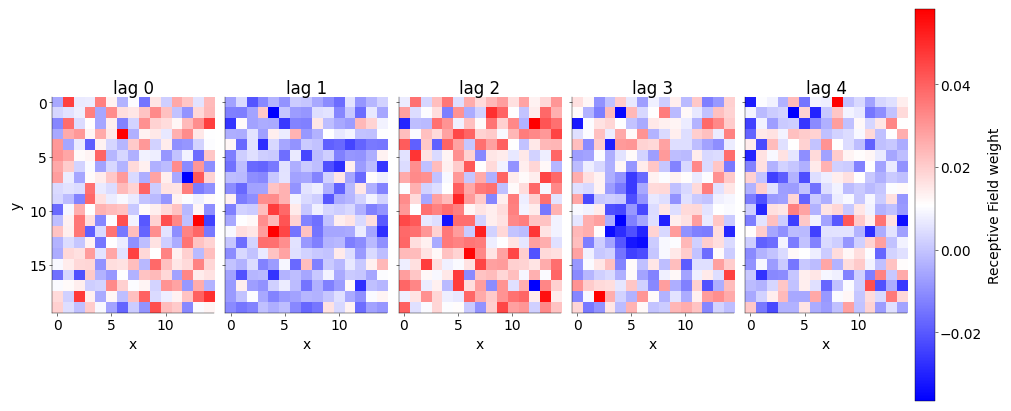

In [12]:
# insert your code here 

# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10,4), constrained_layout=True, sharey=True)
for i in range(5):
    ax[i].imshow(w_hat[:,i].reshape((20,15)), cmap='bwr',)  
    ax[i].set_title("lag {}".format(i))
    ax[i].set_xticks(np.arange(0, 15, 5))
    ax[i].set_yticks(np.arange(0, 20, 5))
    ax[i].set_xlabel("x")
ax[0].set_ylabel("y")   
# adding colorbar to the last plot
cbar= fig.colorbar(ax[4].imshow(w_hat[:,4].reshape((20,15)), cmap='bwr',), ax=ax[4])
cbar.set_label('Receptive Field weight')

## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$


"The left singular vectors (U): These vectors represent the spatial components of the matrix. They describe how the original data points are related to each other in a multi-dimensional space.
The singular values (S): These values represent the importance or strength of each spatial component. They indicate the amount of variation captured by each component.
The right singular vectors (V^T): These vectors represent the temporal components of the matrix. They describe how the original data points change over time. Chatgpt" 

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.


*Grading: 1 pts*

(300, 5)
(5,)
(5, 5)


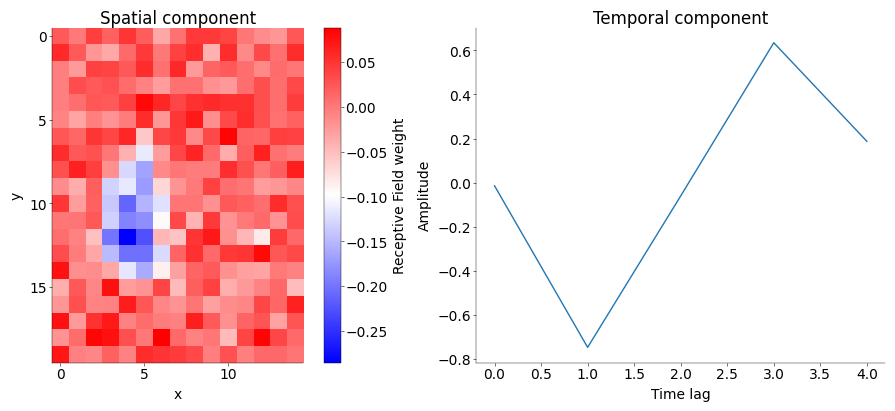

In [13]:
# insert your code here 

# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# shape of w_hat: (300,5). 
# subtract mean along axis=1 (tlytime) since for every timelag the RF is estimated independen
w_hat = w_hat - np.mean(w_hat, axis=1)[:, np.newaxis]

# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)

U, S, V = np.linalg.svd(w_hat, full_matrices=False)
print(U.shape)
print(S.shape)
print(V.shape)

# -------------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[['Spatial', 'Temporal']], figsize=(10,4), constrained_layout=True)
ax['Spatial'].imshow(U[:,0].reshape((20,15)), cmap='bwr')
ax['Spatial'].set_xticks(np.arange(0, 15, 5))
ax['Spatial'].set_yticks(np.arange(0, 20, 5))
ax['Spatial'].set_xlabel("x")
ax['Spatial'].set_ylabel("y")
ax['Spatial'].set_title("Spatial component")
ax['Temporal'].plot(V[0,:])
ax['Temporal'].set_xlabel("Time lag")
ax['Temporal'].set_ylabel("Amplitude")
ax['Temporal'].set_title("Temporal component")
cbar1=fig.colorbar(ax['Spatial'].imshow(U[:,0].reshape((20,15)), cmap='bwr'), ax=ax['Spatial'])
cbar1.set_label('Receptive Field weight')

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


In [14]:
from sklearn import linear_model

# insert your code here 


# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before) 
# with sklern or pyglmnet (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
alpha = 0.01

w_hat = np.zeros((Dx*Dy, 5))
for lag in range(5):
    if lag == 0:
        lml = linear_model.Lasso(alpha=alpha, max_iter=10000)
        lml.fit(s.T, spikes)
    else:
        lml = linear_model.Lasso(alpha=alpha, max_iter=10000)
        lml.fit(s[:,:-lag].T, spikes[lag:])
    w_hat[:, lag] = lml.coef_



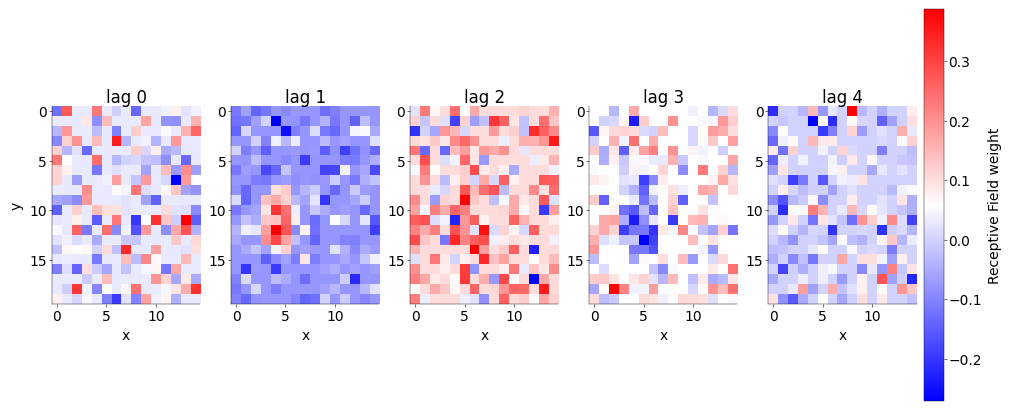

In [15]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10,4), constrained_layout=True)
for i in range(5):
    ax[i].imshow(w_hat[:,i].reshape((20,15)), cmap='bwr',)  
    ax[i].set_title("lag {}".format(i))
    ax[i].set_xticks(np.arange(0, 15, 5))
    ax[i].set_yticks(np.arange(0, 20, 5))
    ax[i].set_xlabel("x")
ax[0].set_ylabel("y")
cbar=fig.colorbar(ax[4].imshow(w_hat[:,4].reshape((20,15)), cmap='bwr',), ax=ax[4])
cbar.set_label('Receptive Field weight')

# add plot